## Environment Setup

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import FuncFormatter


import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *
from utils import *

## Datasets

In [2]:
df = merge_excel_sheets("./raw_data/02__autos_nach_bundesland_kraftstoff.xlsx")
df.head()

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019


## Handling missing values

Check for NaNs

In [3]:
df.isnull().sum()

Land                            0
Kraftstoffart                 126
Kraftfahrzeuge \ninsgesamt      0
Year                            0
dtype: int64

The lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'

In [4]:
# the lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'
df['Kraftstoffart'] = df['Kraftstoffart'].fillna('Total') 
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [5]:
#remove the text "zusammen" or "insgesamt" from the Land
df['Land'] = df['Land'].str.replace(r'\s+zusammen$', '', regex=True)
df['Land'] = df['Land'].str.replace(r'\s+insgesamt$', '', regex=True)


In [6]:
# Remove "Sonstige" from the dataset,since we are interested in the german states
df = df[~(df["Land"] =="Sonstige")]
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [7]:
df ['Kraftstoffart'].value_counts()

Kraftstoffart
Benzin                119
Diesel                119
Gas insgesamt         119
Hybrid insgesamt      119
Total                 119
Sonstige              119
Elektro (BEV)          85
darunter Plug-in       85
Elektro                34
  darunter Plug-in     34
Name: count, dtype: int64

In [8]:
df = df.rename(columns ={'Land':'land', 'Kraftstoffart':'fuel', 'Kraftfahrzeuge \ninsgesamt': 'total_cars', 'Year':'year'})
df

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [9]:
# harmonize the types of "fuel"

fuel_type_mapping = {
 'Benzin': 'Gasoline', 
 'Diesel': 'Diesel', 
 'Gas insgesamt': 'Gas', 
 'Hybrid insgesamt': 'Hybrid total', 
 'Sonstige': 'Sonstige',
 'Elektro (BEV)': 'Electric', 
 'Elektro': 'Electric', 
 'darunter Plug-in': 'Plug-in Hybrid',
 '  darunter Plug-in': 'Plug-in Hybrid'  
 }

df['fuel'] = df['fuel'].replace(fuel_type_mapping)
df["fuel"].value_counts()


fuel
Gasoline          119
Diesel            119
Gas               119
Electric          119
Hybrid total      119
Plug-in Hybrid    119
Sonstige          119
Total             119
Name: count, dtype: int64

Creates one dataframe for Germany (aggregations) and one with the states

In [10]:
# one df for deutschland
df_germany = df [df ["land"] =="Deutschland"].reset_index()
df_states = df [~(df ["land"] =="Deutschland")].reset_index()


Creates one dataframe for Germany in 2025 and save it as csv

In [11]:
df_germany_2025 = df_germany[df_germany ["year"] == 2025]
df_germany_2025.to_csv('./clean_data/autos_germany_fuel_2025.csv', index=False)

In [12]:
# we consider electric and hybrid as electrical, since they all use the charging stations
electric_types = ["Electric"]#, "Plug-in Hybrid"]

# filter the electrical vehicles
eautos = df_germany [df_germany["fuel"].isin(electric_types)]
# summs the electrical vehicles
e_autos_germany = eautos.groupby("year").agg(
    number_of_electric_cars=("total_cars", "sum")      
).reset_index()

e_autos_germany


,year,number_of_electric_cars
0,2019,112119
1,2020,174625
2,2021,358498
3,2022,683958
4,2023,1139734
5,2024,1555265
6,2025,1810815


In [13]:
total_autos = df_germany [df_germany["fuel"] == 'Total']


In [14]:
total_autos.drop(columns = ['land', 'fuel'], inplace = True)
total_autos.reset_index(drop=True)
total_autos

,index,total_cars,year
7,143,57305201,2019
15,287,58158344,2020
23,431,59020091,2021
31,575,59635446,2022
39,719,60133124,2023
47,863,60680636,2024
55,1007,61097943,2025


In [15]:
total_cars_germany = total_autos.merge(e_autos_germany, on ='year', how = 'left')
total_cars_germany

,index,total_cars,year,number_of_electric_cars
0,143,57305201,2019,112119
1,287,58158344,2020,174625
2,431,59020091,2021,358498
3,575,59635446,2022,683958
4,719,60133124,2023,1139734
5,863,60680636,2024,1555265
6,1007,61097943,2025,1810815


In [16]:
total_cars_germany.to_csv("./clean_data/total_cars_germany.csv", index = False)

In [17]:
charging_stations_germany = pd.read_csv('./clean_data/stations_germany.csv', usecols= ['number_of_charging_points', 'year'])

# only considers charging stations starting from 2019, to match the other datasets
charging_stations_germany = charging_stations_germany [charging_stations_germany["year"] > 2018]

# merges the two datasets
charging_stations_germany = charging_stations_germany.merge(e_autos_germany, on = "year", how = "left")

charging_stations_germany

,number_of_charging_points,year,number_of_electric_cars
0,19812,2019,112119
1,31006,2020,174625
2,44528,2021,358498
3,62099,2022,683958
4,89913,2023,1139734
5,130504,2024,1555265
6,160809,2025,1810815


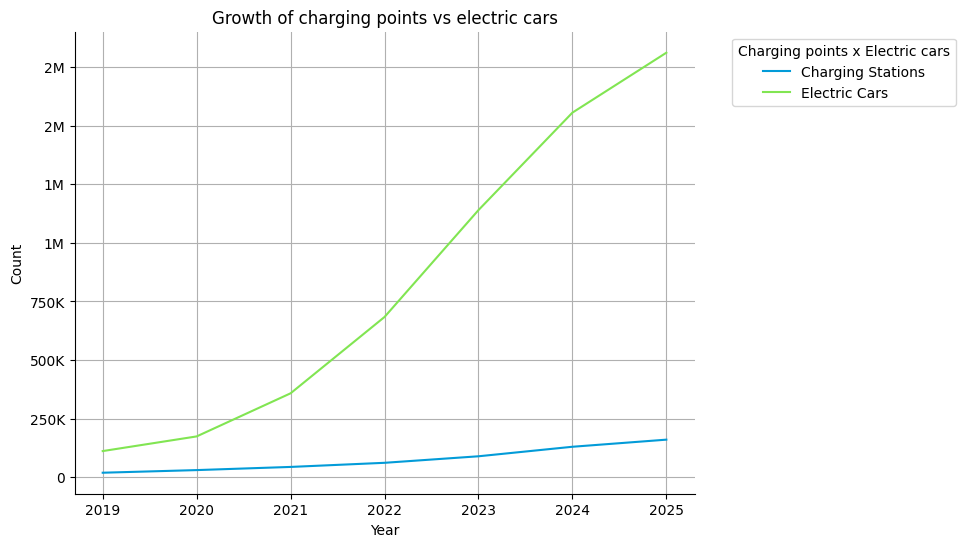

In [18]:
plt.figure(figsize=(8, 6))
    
sns.lineplot(data = charging_stations_germany, x ='year', y ='number_of_charging_points', label='Charging Stations', color = "#029BD8")
sns.lineplot(data = charging_stations_germany, x ='year', y = 'number_of_electric_cars', label='Electric Cars', color = "#81E552")
sns.despine()

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))
plt.xlabel('Year')
plt.ylabel('Count')


plt.title('Growth of charging points vs electric cars')
plt.grid(True)
# Move legend outside
plt.legend(title="Charging points x Electric cars", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [19]:

df = total_cars_germany

# Sort by year in case it's not sorted
df = df.sort_values('year')

# Compute the number of new cars and new electric cars per year
df['new_total_cars'] = df['total_cars'].diff()
df['new_electric_cars'] = df['number_of_electric_cars'].diff()

# Drop the first row with NaN from diff
df = df.dropna()




Plots the current development and the predictions for both charging points and electric cars

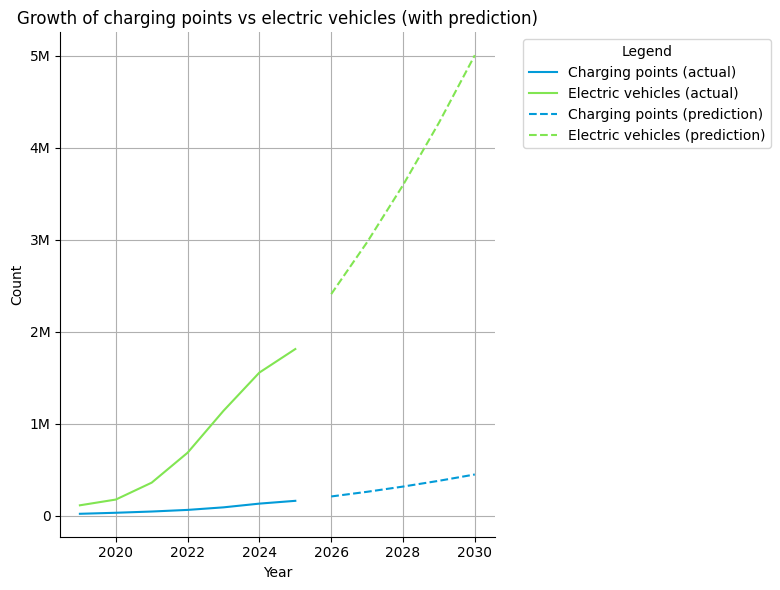

In [20]:
# Degree of the polynomial
poly_degree = 2

# Create polynomial feature transformer
poly = PolynomialFeatures(degree=poly_degree)

# Future years to predict
future_years = np.arange(charging_stations_germany['year'].max() + 1, 2031)
future_df = pd.DataFrame({'year': future_years})

# Train and predict for electric cars
X_cars = poly.fit_transform(charging_stations_germany[['year']])
y_cars = charging_stations_germany['number_of_electric_cars']
model_cars = LinearRegression().fit(X_cars, y_cars)
future_df['number_of_electric_cars'] = model_cars.predict(poly.transform(future_df[['year']]))

# Train and predict for charging stations
X_stations = poly.fit_transform(charging_stations_germany[['year']])
y_stations = charging_stations_germany['number_of_charging_points']
model_stations = LinearRegression().fit(X_stations, y_stations)
future_df['number_of_charging_points'] = model_stations.predict(poly.transform(future_df[['year']]))

# Plotting
plt.figure(figsize=(8, 6))

# Actual data
sns.lineplot(data=charging_stations_germany, x='year', y='number_of_charging_points', label='Charging points (actual)', color="#029BD8")
sns.lineplot(data=charging_stations_germany, x='year', y='number_of_electric_cars', label='Electric vehicles (actual)', color="#81E552")

# Predictions
sns.lineplot(data=future_df, x='year', y='number_of_charging_points', label='Charging points (prediction)', color="#029BD8", linestyle='--')
sns.lineplot(data=future_df, x='year', y='number_of_electric_cars', label='Electric vehicles (prediction)', color="#81E552", linestyle='--')

# Styling
sns.despine()
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Growth of charging points vs electric vehicles (with prediction)')
plt.grid(True)

# Move legend outside
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()




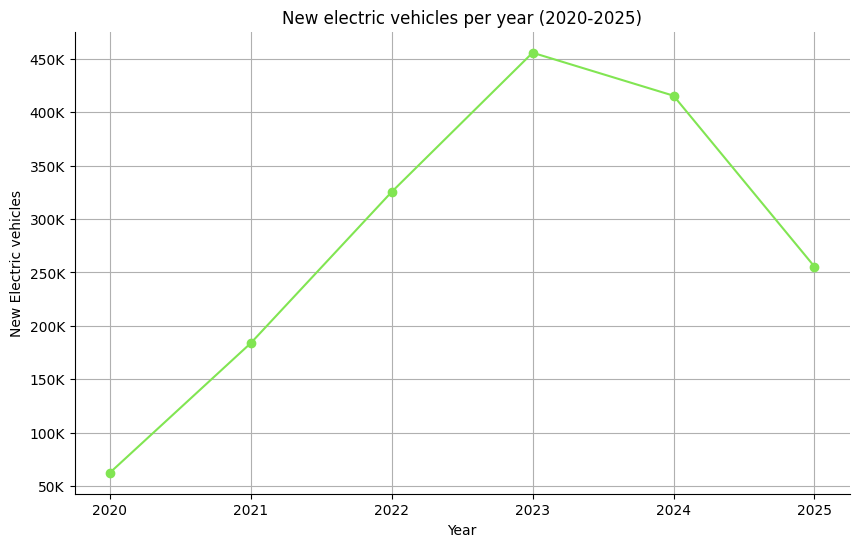

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['new_electric_cars'], marker='o', color = '#81E552')

ax = plt.gca();
format_axes(ax)


plt.title('New electric vehicles per year (2020-2025)')
plt.xlabel('Year')
plt.ylabel('New Electric vehicles')
plt.grid(True)
plt.show()

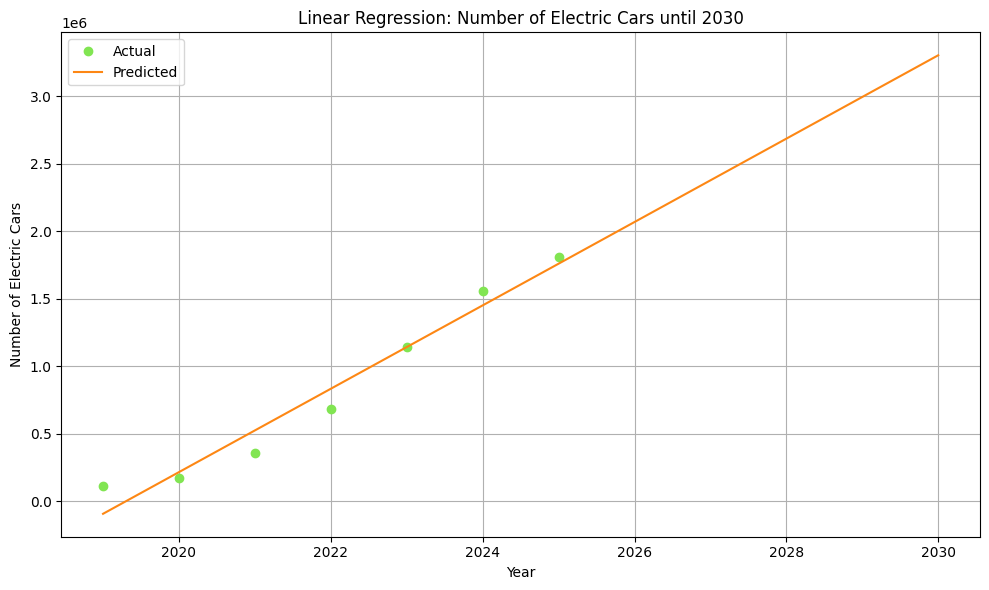

In [22]:
df = charging_stations_germany

# Train linear regression on year vs number_of_electric_cars
X = df[['year']]
y = df['number_of_electric_cars']

model = LinearRegression()
model.fit(X, y)

# Predict up to 2030
future_years = np.arange(2019, 2031).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['number_of_electric_cars'], 'o', label='Actual', color = "#81E552" )
plt.plot(future_years.flatten(), future_predictions, '-', label='Predicted', color = "#FD8714" )

plt.title("Linear Regression: Number of Electric Cars until 2030")
plt.xlabel("Year")
plt.ylabel("Number of Electric Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


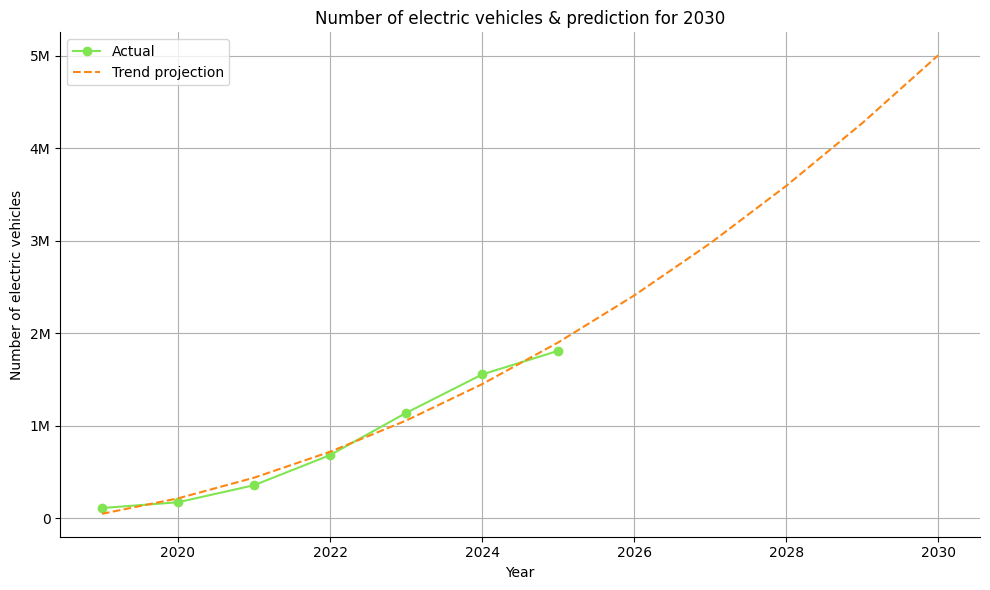

In [23]:
df = charging_stations_germany

# Set up polynomial regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['year']])
y = df['number_of_electric_cars']

model = LinearRegression()
model.fit(X_poly, y)

# Predict for current and future years
future_years = np.arange(2019, 2031).reshape(-1, 1)
future_X_poly = poly.transform(future_years)
future_predictions = model.predict(future_X_poly)

current_predictions = model.predict(poly.transform(df[['year']]))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['number_of_electric_cars'], 'o-', label='Actual', color="#81E552")
#plt.plot(df['year'], current_predictions, '-', color="#81E552", alpha=0.7, label='Polynomial Fit (current)')
plt.plot(future_years.flatten(), future_predictions, '--', label='Trend projection', color="#FD8714")

ax = plt.gca()
format_axes(ax)

plt.title("Number of electric vehicles & prediction for 2030")
plt.xlabel("Year")
plt.ylabel("Number of electric vehicles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
correlation = charging_stations_germany['number_of_electric_cars'].corr(charging_stations_germany['number_of_charging_points'])
print(f'Correlation: {correlation:.2f}')

Correlation: 0.99


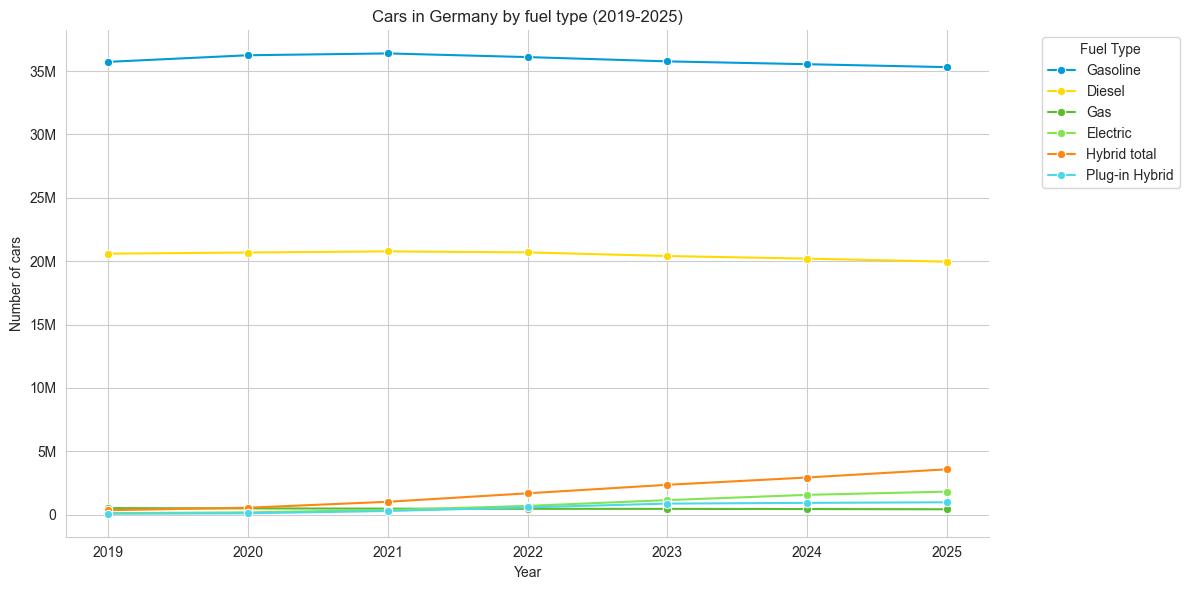

In [25]:
# Set the plot style
sns.set_style("whitegrid")

    
# excludes total, as it includes all the fuel types
df_germany_filtered = df_germany[~(df_germany["fuel"].isin(["Total","Sonstige"]))]

# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_germany_filtered, x="year", y="total_cars", palette = colors_fuel, hue="fuel", marker="o")

# Access the axes
ax = plt.gca()

# Format ticks with commas
format_axes(ax)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of cars")
plt.title("Cars in Germany by fuel type (2019-2025)")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()
plt.show()

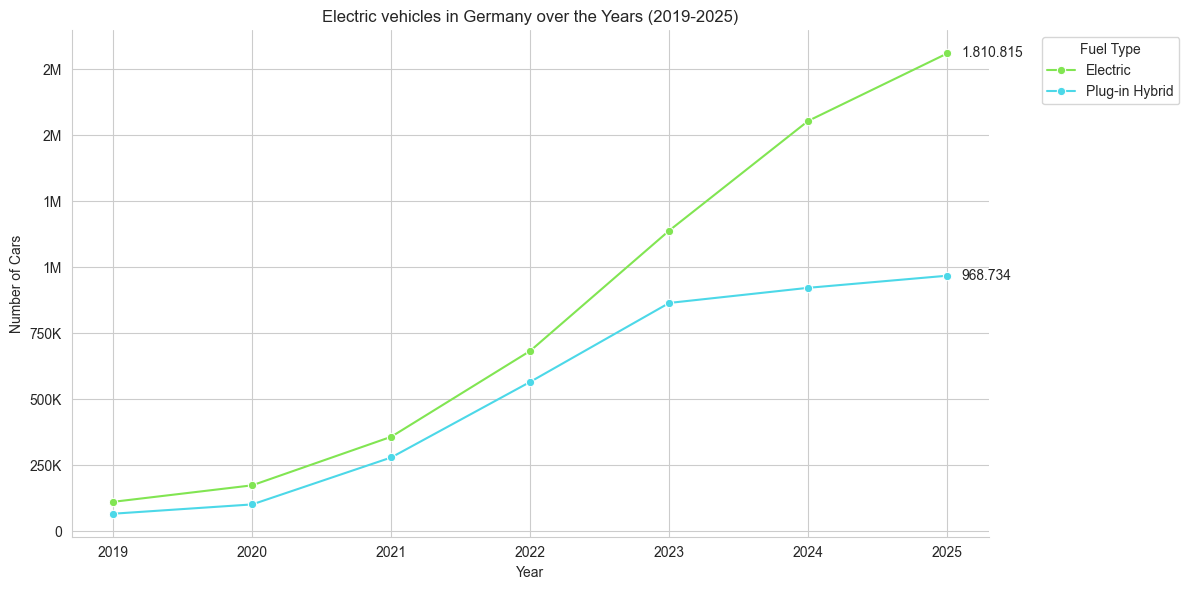

In [26]:
# here we consider pure electrical and plug-in hybrids as electrical cars
df_electric = df_germany[df_germany["fuel"].isin(["Electric", "Plug-in Hybrid"])]

# Set the plot style
#sns.set_style("whitegrid")


# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))

# Access the axes
ax = plt.gca()

# Turn off scientific notation
ax.ticklabel_format(style='plain', axis='y')


format_axes(ax)

sns.lineplot(data=df_electric, x="year", y="total_cars", palette = colors_fuel, hue="fuel", marker="o", ax = ax)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.title("Electric vehicles in Germany over the Years (2019-2025)")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()

# Annotate the last value of each line
for fuel_type, group_data in df_electric.groupby("fuel"):
    last_point = group_data.sort_values("year").iloc[-1]
    x = last_point["year"]
    y = last_point["total_cars"]
    label = f'{int(y):,}'.replace(',', '.')

    # Slight offset to avoid overlapping with the point
    ax.text(x + 0.1, y, label, va='center', fontsize=10)


plt.show()

In [27]:
df_states.to_csv('./clean_data/cars_based_on_fuel_per_year.csv',  index=False)

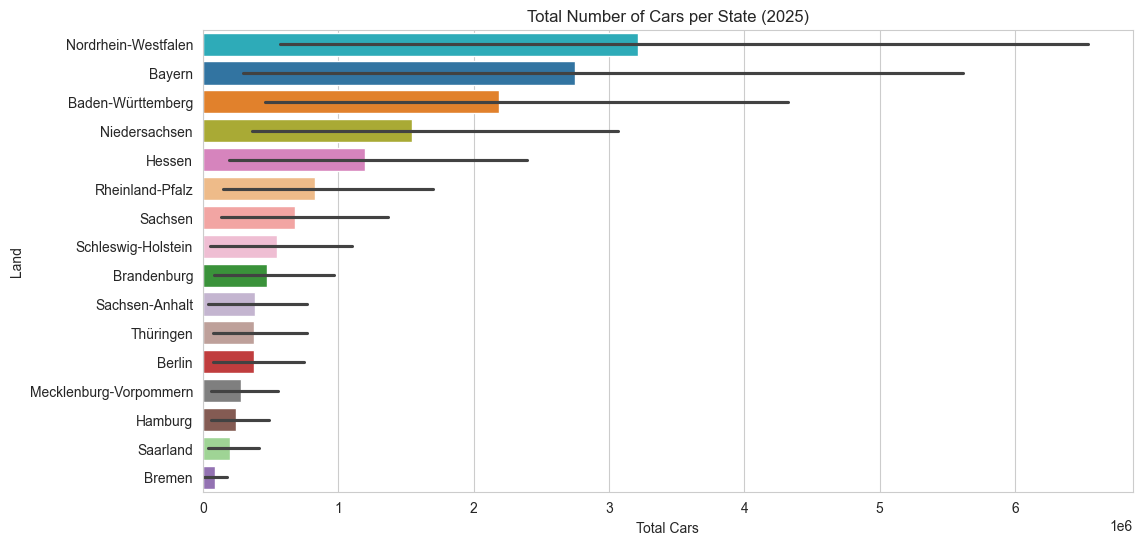

In [28]:
# Filter data for 2025
df_2025 = df_states[df_states["year"] == 2025]

# Sort by total number of cars for better visualization
df_2025 = df_2025.sort_values(by="total_cars", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_2025, x="total_cars", y="land", palette=german_states_colors)

# Labels and title
plt.xlabel("Total Cars")
plt.ylabel("Land")
plt.title("Total Number of Cars per State (2025)")

# Show the plot
plt.show()


### Creates a new dataframe

Creates a Dataframe with the information about the year 2025

In [29]:
autos_2025 = df_states [df_states["year"] == 2025]
autos_2025.rename(columns = {"land":"state"}, inplace=True)

# we consider electric and hybrid as electrical, since they all use the charging stations
electric_types = ["Electric", "Plug-in Hybrid"]

# filter the electrical vehicles
eautos_2025 = autos_2025[autos_2025["fuel"].isin(electric_types)]
# summs the electrical vehicles
e_autos_per_state_2025 = eautos_2025.groupby("state").agg(
    number_of_electric_cars=("total_cars", "sum")     
).reset_index()

e_autos_per_state_2025.head()



,state,number_of_electric_cars
0,Baden-Württemberg,447516
1,Bayern,508858
2,Berlin,77486
3,Brandenburg,57883
4,Bremen,15280


In [30]:
# filter the total of cars
total_cars_2025 = autos_2025 [autos_2025['fuel'] == 'Total']
total_cars_2025.drop(columns=['fuel', 'year'], inplace=True)                    
                     

Merges the total of electrical cars with the total of cars, and adds a column total of non-electric

In [31]:
autos_state_2025 = e_autos_per_state_2025.merge(total_cars_2025, on = "state", how="left")

In [32]:
autos_state_2025['number_non_electric_cars'] = autos_state_2025['total_cars'] - autos_state_2025['number_of_electric_cars']
autos_state_2025.rename (columns = {'total_cars':'number_cars'}, inplace = True)
autos_state_2025


,state,number_of_electric_cars,index,number_cars,number_non_electric_cars
0,Baden-Württemberg,447516,871,8662899,8215383
1,Bayern,508858,879,10907517,10398659
2,Berlin,77486,887,1492346,1414860
3,Brandenburg,57883,895,1891574,1833691
4,Bremen,15280,903,349764,334484
5,Hamburg,63864,911,955424,891560
6,Hessen,247801,919,4746596,4498795
7,Mecklenburg-Vorpommern,26345,927,1124068,1097723
8,Niedersachsen,271977,935,6144748,5872771
9,Nordrhein-Westfalen,654721,943,12737736,12083015


In [33]:
autos_state_2025.to_csv("./clean_data/autos_state_2025.csv", index = False)

In [34]:
# Filter for electric and plug-in hybrid cars
electric_types = ["Electric", "Plug-in Hybrid"]
df_total_electric = df_states[df_states["fuel"].isin(electric_types)]

# Group by land and year to get total electric cars
electric_summary = df_total_electric.groupby(["land", "year"])["total_cars"].sum().reset_index()
electric_summary.rename(columns={"total_cars": "total_electric"}, inplace=True)



In [35]:
# Check for rows where the fuel column is "Total"
df_total_flag = df_states[df_states["fuel"].str.lower() == "total"]

# Keep only these rows as the actual total per state/year
total_cars_summary_corrected = df_total_flag[["land", "year", "total_cars"]].copy()
total_cars_summary_corrected.rename(columns={"total_cars": "total_all"}, inplace=True)

# Reuse the already computed total electric (electric + plug-in hybrid)
# electric_summary is already grouped by land and year
# Merge with the corrected total cars
merged_df_corrected = pd.merge(total_cars_summary_corrected, electric_summary, on=["land", "year"], how="left")
merged_df_corrected["total_electric"] = merged_df_corrected["total_electric"].fillna(0).astype(int)
merged_df_corrected["total_non_electric"] = merged_df_corrected["total_all"] - merged_df_corrected["total_electric"]

# Select and reorder columns
final_df_corrected = merged_df_corrected[["land", "total_electric", "total_non_electric", "year"]]

final_df_corrected.head()


,land,total_electric,total_non_electric,year
0,Baden-Württemberg,32226,8078916,2019
1,Bayern,38640,10111968,2019
2,Berlin,5537,1428604,2019
3,Brandenburg,3358,1756562,2019
4,Bremen,931,336240,2019
